In [1]:
from collections import defaultdict, Counter
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import minimize_scalar
%matplotlib inline

In [2]:
# _df = pd.concat([
#     pd.read_csv('/Users/mario/code/pb_speaker_adaptation/src/analysis/19dec/appliances.csv'),
#     pd.read_csv('/Users/mario/code/pb_speaker_adaptation/src/analysis/19dec/food.csv'),
#     pd.read_csv('/Users/mario/code/pb_speaker_adaptation/src/analysis/19dec/indoor.csv'),
#     pd.read_csv('/Users/mario/code/pb_speaker_adaptation/src/analysis/19dec/outdoor.csv'),
#     pd.read_csv('/Users/mario/code/pb_speaker_adaptation/src/analysis/19dec/vehicles.csv')
# ])

_df = pd.read_csv('/Users/mario/code/pb_speaker_adaptation/src/analysis/19dec/all.csv')


# _df = pd.read_csv(
    # '/Users/mario/code/pb_speaker_adaptation/src/analysis/19dec/all.csv')
    # ,
    # error_bad_lines=False, warn_bad_lines=True)


/var/folders/0s/847v13g104z23kr193w_v2640000gn/T/ipykernel_19938/2315544405.py:9: DtypeWarning: Columns (29,30,31,32,33,34,35,36,54,55,56,57,58,59,60,61,102,103,104,105,106,107,108,109,128,129,130,131,132,133,134,135,152,153,154,155,156,157,158,159) have mixed types. Specify dtype option on import or set low_memory=False.
  _df = pd.read_csv('/Users/mario/code/pb_speaker_adaptation/src/analysis/19dec/all.csv')


In [35]:
# pd.to_numeric(df['target domain'], errors='coerce')

print('target domain   :', _df['target domain'].unique())
print('listener domain :', _df['listener domain'].unique())
print('simulator domain:', _df['simulator domain'].unique())
_df = _df.dropna()
print('Data points:', len(_df))

_df = _df[_df['listener domain'] != 'all']
_df = _df[_df['simulator domain'] != 'all']

id_df = _df[(_df['target domain'] == _df['listener domain'])]
ood_df = _df[(_df['target domain'] != _df['listener domain'])]

# df = ood_df
# df.head(2)


target domain   : ['food' 'vehicles' 'outdoor' 'indoor' 'appliances']
listener domain : ['appliances' 'food' 'indoor' 'outdoor' 'vehicles']
simulator domain: ['appliances' 'food' 'indoor' 'outdoor' 'vehicles']
Data points: 1442


In [27]:
# df = df[df['target domain'] != df['listener domain']]
df = df[df['listener domain'] != 'all']
df = df[df['simulator domain'] != 'all']
print('OOD data points:', len(df))

OOD data points: 1412


In [3]:
N_STEPS = 24

refs = _df['golden utt'].tolist()

hyps = {"h0": _df['original utt'].tolist()}
hyps.update(
    {f"h0 {s}": _df[f"adapted utt s{s}"].tolist() for s in range(N_STEPS)}
)
for k in hyps:
    hyps[k] = [x for x in hyps[k] if type(x) == str]
hyps.keys()

dict_keys(['h0', 'h0 0', 'h0 1', 'h0 2', 'h0 3', 'h0 4', 'h0 5', 'h0 6', 'h0 7', 'h0 8', 'h0 9', 'h0 10', 'h0 11', 'h0 12', 'h0 13', 'h0 14', 'h0 15', 'h0 16', 'h0 17', 'h0 18', 'h0 19', 'h0 20', 'h0 21', 'h0 22', 'h0 23'])

In [4]:
vocabs = defaultdict(lambda: Counter())

for ref in refs:
    for tok in ref.strip().split():
        vocabs['ref'][tok] += 1

for hyp_type in hyps:
    for hyp in hyps[hyp_type]:
        for tok in hyp.strip().split():
            vocabs[hyp_type][tok] += 1


In [5]:
def neg_zipf_likelihood(s):
    n = sum(freq_of_word_counts)
    # for each word count, find the probability that a random word has such word count
    probas = word_counts ** (-s) / np.sum(np.arange(1, n+1) **(-s))
    log_likelihood = sum(np.log(probas) * word_counts)
    return -log_likelihood


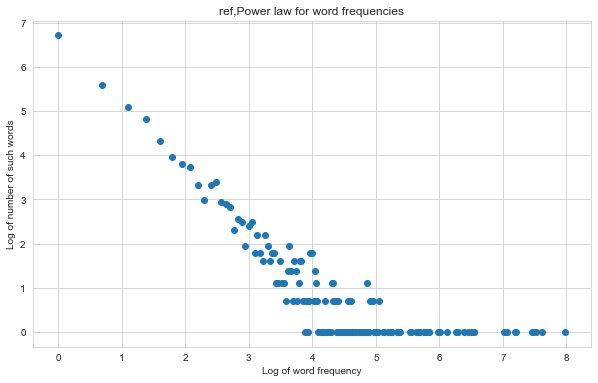

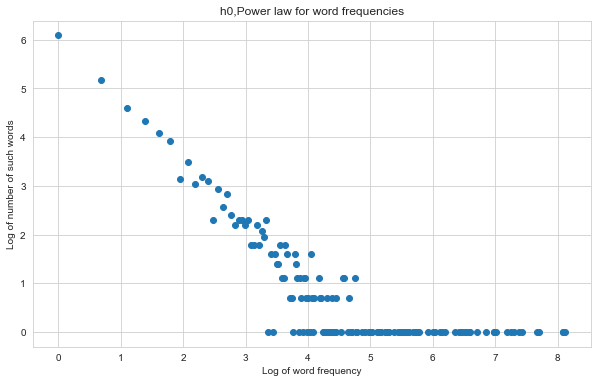

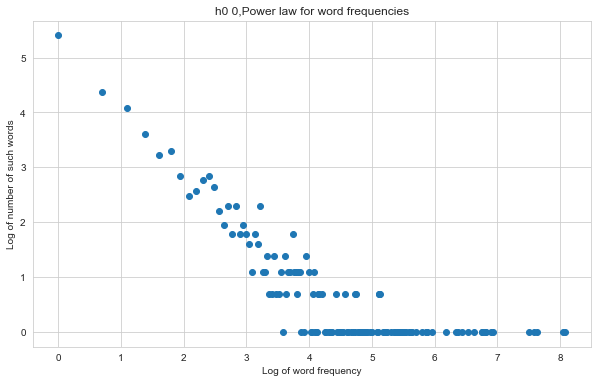

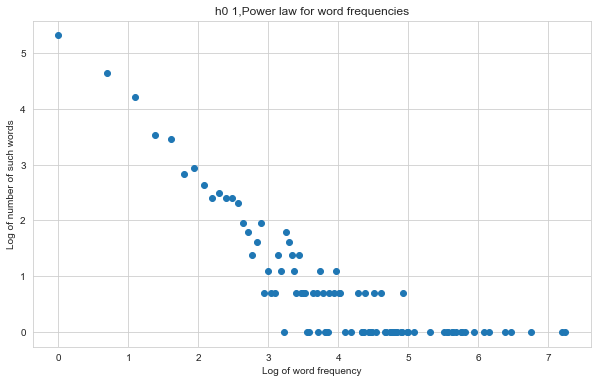

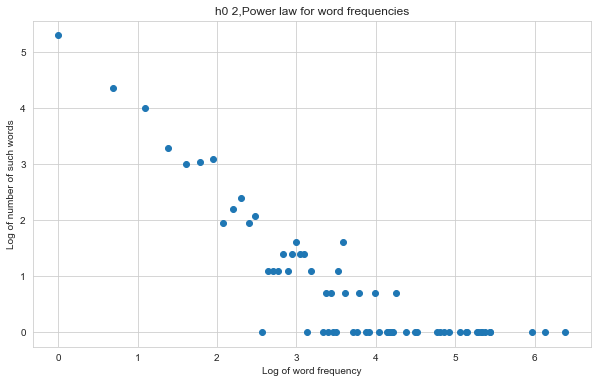

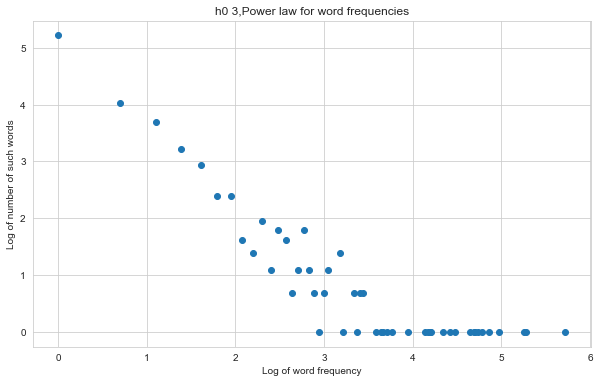

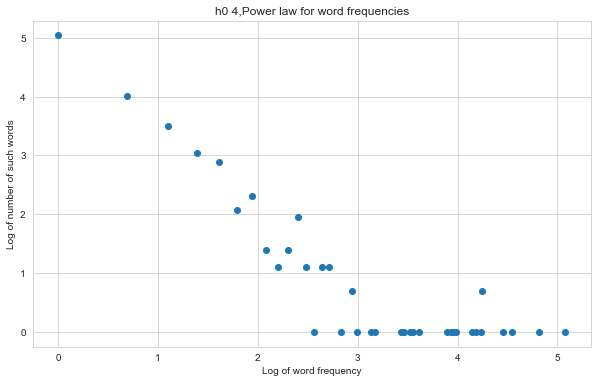

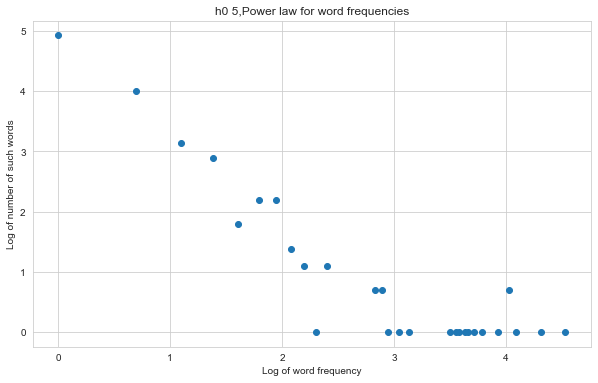

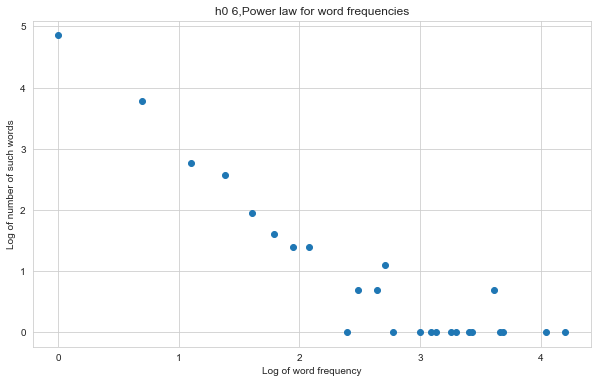

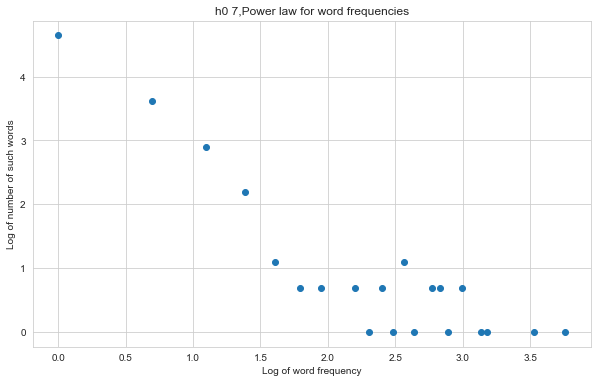

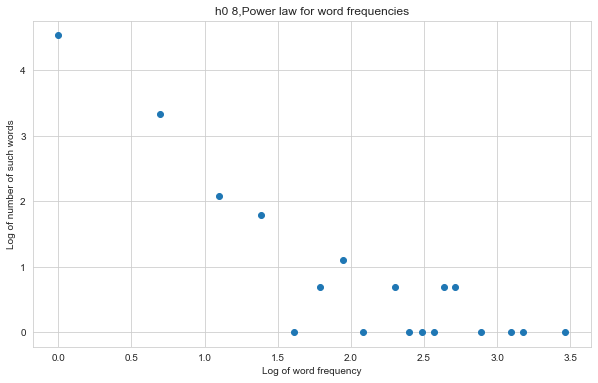

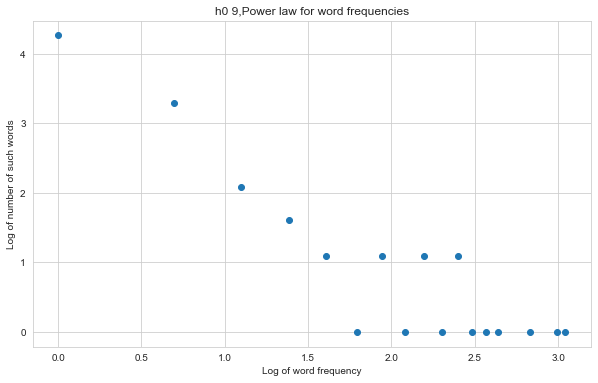

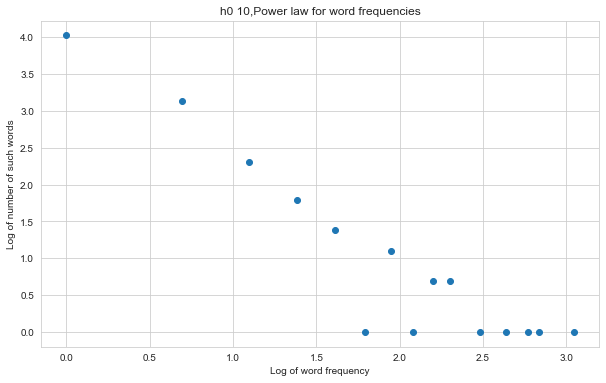

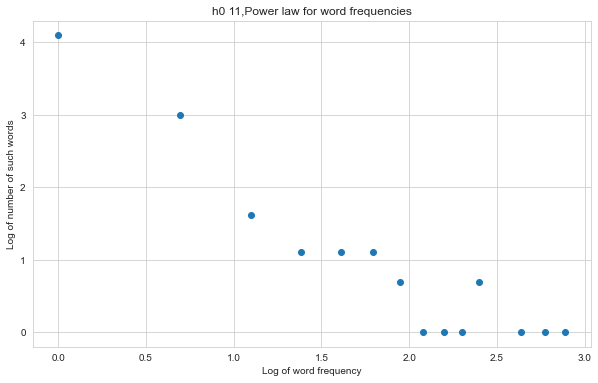

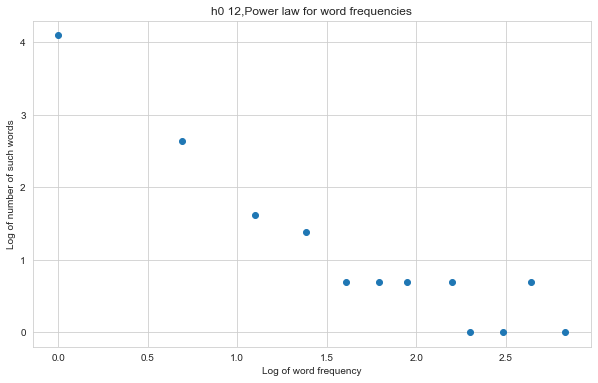

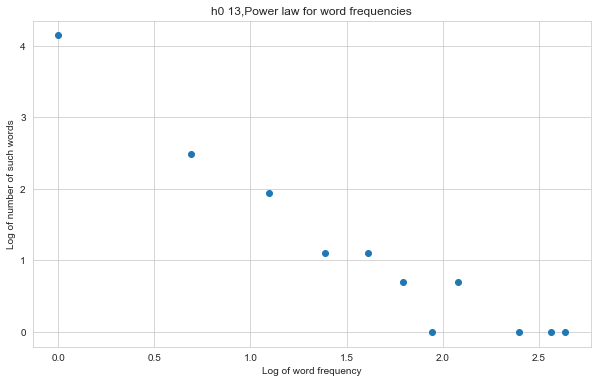

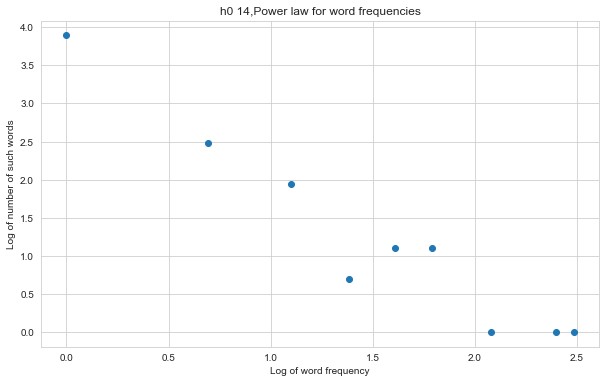

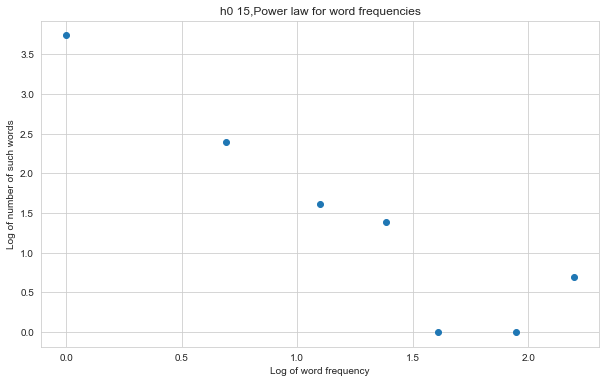

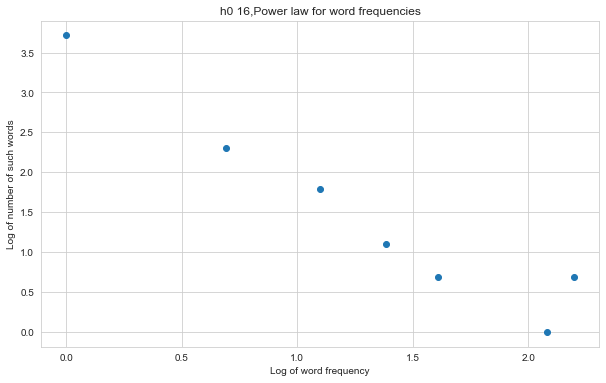

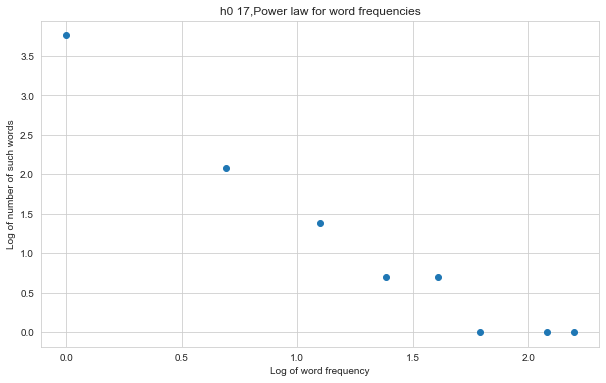

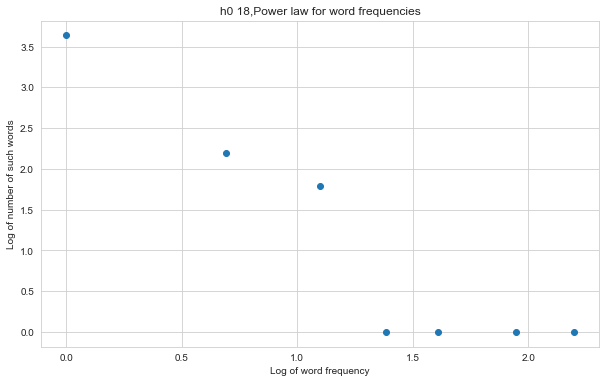

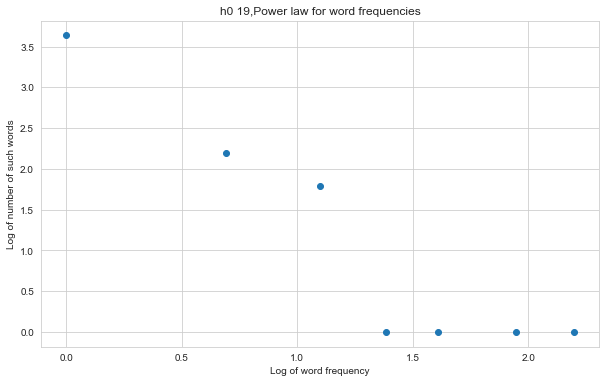

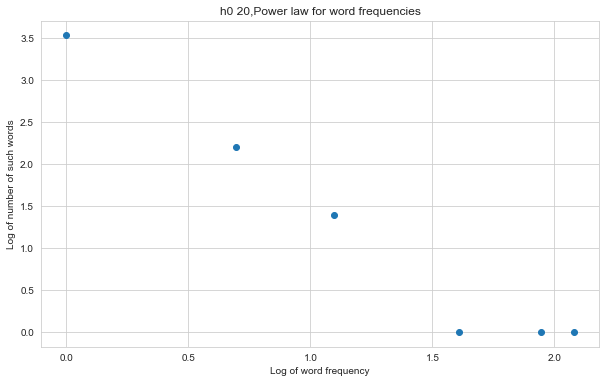

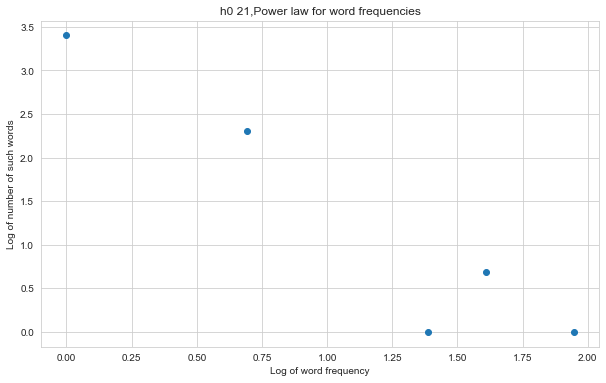

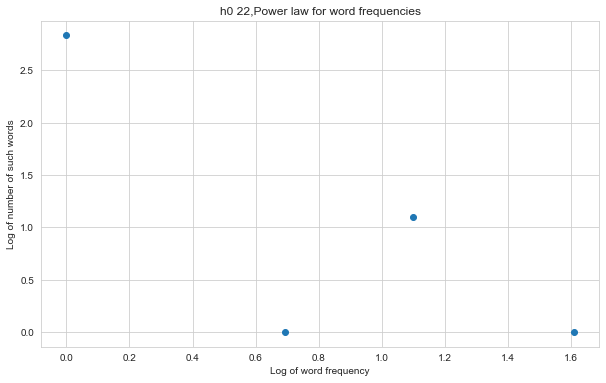

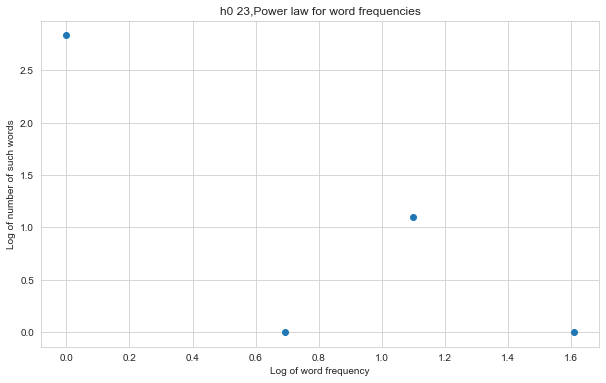

In [6]:
plt.rcParams["figure.figsize"] = (10,6)

for typ in ['ref'] + list(hyps.keys()):

    counter_of_words = vocabs[typ]
    counter_of_counts = Counter(counter_of_words.values())
    word_counts = np.array(list(counter_of_counts.keys()))
    freq_of_word_counts = np.array(list(counter_of_counts.values()))

    # s_best = minimize_scalar(neg_zipf_likelihood)
    # print()

    plt.scatter(np.log(word_counts), np.log(freq_of_word_counts))
    plt.xlabel('Log of word frequency')
    plt.ylabel('Log of number of such words')
    plt.title(f'{typ},Power law for word frequencies') # (s = {:.2f})'.format(s_best.x))
    plt.show();

for typ in ['ref'] + list(hyps.keys()):
    vocab_df = pd.DataFrame.from_records(vocabs[typ].most_common(), columns=['word','frequency'])
    ax = vocab_df.plot.bar(x='word', y='frequency', title=typ)
    plt.show()

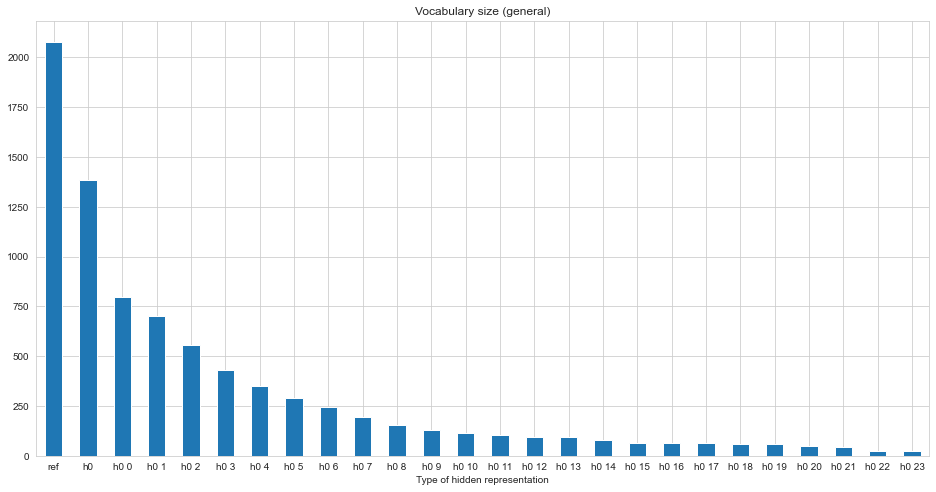

In [8]:
plt.rcParams["figure.figsize"] = (16,8)

types = ['ref'] + list(hyps.keys())

size_df = pd.DataFrame({
    'Type of hidden representation': types,
    'Vocab size': [len(vocabs[x]) for x in types]
})

ax = size_df.plot.bar(x='Type of hidden representation', y='Vocab size', rot=0, title='Vocabulary size (general)')
plt.legend().remove()

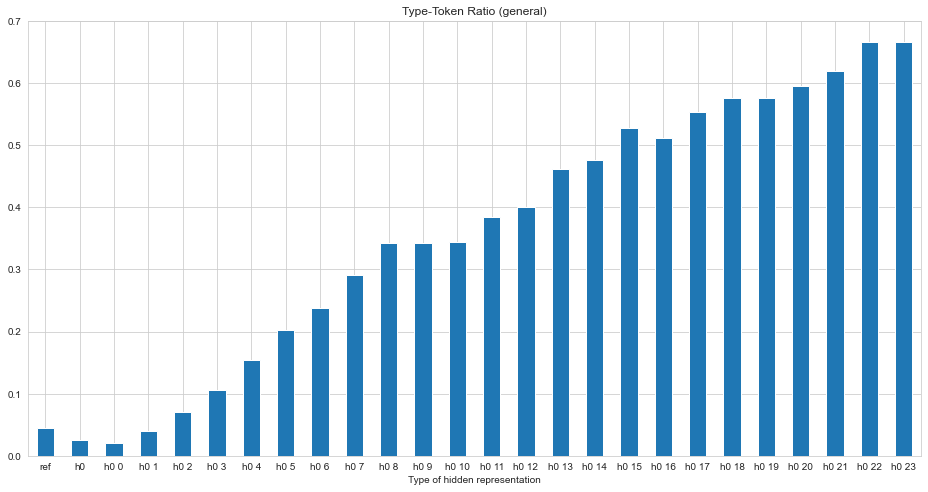

In [9]:
ttr = []
for typ in types:
    ttr.append(len(vocabs[typ]) / sum(vocabs[typ].values()) )

ttr_df = pd.DataFrame({
    'Type of hidden representation': types,
    'ttr': ttr
})

ax = ttr_df.plot.bar(x='Type of hidden representation', y='ttr', rot=0, title='Type-Token Ratio (general)')
plt.legend().remove()